In [1]:
import sklearn.datasets
from sklearn.cross_validation import train_test_split
import re
import tensorflow as tf
from sklearn import metrics
import numpy as np
import collections
import time

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def clearstring(string):
    string = re.sub('[^A-Za-z ]+', '', string)
    string = string.split('\n')
    string = [y.strip() for y in filter(None, string)]
    string = (' '.join(string)).lower()
    return ' '.join([y.strip() for y in string.split()])

def separate_dataset(trainset):
    datastring = []
    datatarget = []
    for i in range(len(trainset.data)):
        data_ = trainset.data[i].split('\n')
        data_ = list(filter(None, data_))
        for n in range(len(data_)):
            data_[n] = clearstring(data_[n])
        datastring += data_
        for n in range(len(data_)):
            datatarget.append(trainset.target[i])
    return datastring, datatarget

In [3]:
newsgroups_train = sklearn.datasets.load_files(container_path = '/home/husein/space/text-dataset/polarity/data', encoding = 'UTF-8')
newsgroups_train.data, newsgroups_train.target = separate_dataset(newsgroups_train)
_,newsgroups_train.data,_,newsgroups_train.target=train_test_split(newsgroups_train.data,
                                                                 newsgroups_train.target,
                                                                 test_size = 0.2)

In [4]:
len(newsgroups_train.data)

2133

In [5]:
for i in range(len(newsgroups_train.data)):
    newsgroups_train.data[i] = clearstring(newsgroups_train.data[i])

In [6]:
texts = ' '.join(newsgroups_train.data)
words = texts.split()
word2freq = collections.Counter(words)
print("Total words:", len(words))

Total words: 38609


In [7]:
_words = ['PAD','UNK']+list(set(words))
word2idx = {c: i for i, c in enumerate(_words)}
idx2word = {i: c for i, c in enumerate(_words)}
vocab_size = len(idx2word)
indexed = [word2idx[w] for w in words]
print('Vocabulary size:', vocab_size)

Vocabulary size: 8179


In [8]:
class CBOW:
    def __init__(self, sample_size, vocab_size, embedded_size, window_size=3):
        self.X = tf.placeholder(tf.int32, shape=[None, 2*window_size])
        self.Y = tf.placeholder(tf.int32, shape=[None, 1])
        self.embedding = tf.Variable(tf.truncated_normal([vocab_size, embedded_size],
                                                      stddev=1.0 / np.sqrt(embedded_size)))
        self.bias = tf.Variable(tf.zeros([vocab_size]))
        embedded = tf.nn.embedding_lookup(self.embedding, self.X)
        embedded = tf.reduce_mean(embedded, axis=1)
        self.cost = tf.reduce_mean(tf.nn.nce_loss(
            weights=self.embedding,
            biases=self.bias,
            labels=self.Y,
            inputs=embedded,
            num_sampled=sample_size,
            num_classes=vocab_size))
        self.optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(self.cost)
        self.valid_dataset = tf.placeholder(tf.int32, shape=[None])
        norm = tf.sqrt(tf.reduce_sum(tf.square(self.embedding), 1, keep_dims=True))
        self.normalized_embeddings = self.embedding / norm
        valid_embeddings = tf.nn.embedding_lookup(self.normalized_embeddings, self.valid_dataset)
        self.similarity = tf.matmul(valid_embeddings, self.normalized_embeddings, transpose_b=True)

In [9]:
mean_length = int(np.mean([len(i.split()) / 2 for i in newsgroups_train.data]))

In [10]:
batch_size = 32
embedded_size = 32
window_size = mean_length
epoch = 5
valid_size = 10
nearest_neighbors = 8

In [11]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = CBOW(batch_size,vocab_size,embedded_size,window_size)
sess.run(tf.global_variables_initializer())

In [12]:
def get_x(words, idx):
    left = idx - window_size
    right = idx + window_size
    return words[left: idx] + words[idx+1: right+1]

def make_xy(int_words):
    x,y = [], []
    for i in range(window_size, len(int_words)-window_size):
        inputs = get_x(int_words, i)
        x.append(inputs)
        y.append(int_words[i])
    return np.array(x), np.array(y)

In [13]:
X, Y = make_xy(indexed)

In [14]:
for i in range(epoch):
    total_cost = 0
    for k in range(0,(X.shape[0] // batch_size) * batch_size,batch_size):
        batch_x = X[k:k+batch_size]
        batch_y = Y[k:k+batch_size,np.newaxis]
        cost,_ = sess.run([model.cost,model.optimizer],feed_dict={model.X:batch_x,
                                                                 model.Y:batch_y})
        total_cost += cost
    total_cost /= (X.shape[0] // batch_size)
    print('epoch %d, avg loss %f'%(i+1,total_cost))
    random_valid_size = np.random.choice(indexed, valid_size)
    similarity = sess.run(model.similarity,feed_dict={model.valid_dataset:random_valid_size})
    for no, i in enumerate(random_valid_size):
        valid_word = idx2word[i]
        nearest = (-similarity[no, :]).argsort()[1:nearest_neighbors + 1]
        log_str = 'Nearest to %s:' % valid_word
        for k in range(nearest_neighbors):
            close_word = idx2word[nearest[k]]
            log_str = '%s %s,' % (log_str, close_word)
        print(log_str)

epoch 1, avg loss 40.446704
Nearest to and: to, that, this, with, his, into, an, not,
Nearest to rich: events, schaeffers, runnerup, concerned, powered, concocted, transported, fax,
Nearest to to: that, this, and, his, with, not, into, is,
Nearest to the: its, is, this, be, that, an, than, his,
Nearest to is: its, this, to, that, than, as, with, and,
Nearest to justice: brought, hats, turning, screen, remember, last, scenes, takes,
Nearest to role: high, jokes, rollerball, jay, also, show, exactly, sendup,
Nearest to us: fun, show, run, even, it, the, but, new,
Nearest to that: his, to, this, with, and, be, is, more,
Nearest to writerdirector: kiosks, silence, notexactly, post, shooting, weighty, seem, awardswith,
epoch 2, avg loss 16.582542
Nearest to of: this, an, from, can, in, out, even, es,
Nearest to about: more, can, in, us, but, an, with, though,
Nearest to actually: wiels, thankfully, frames, inquiries, reputation, everythings, nuanced, stalking,
Nearest to the: in, an, is, th

In [15]:
del X, Y

In [60]:
documents_size = len(newsgroups_train.data)
documents_embedded = 300
sample_size = 32
docs_idx = np.arange(len(newsgroups_train.data))
embedded_words = sess.run(model.normalized_embeddings)

In [61]:
class Embedded:
    def __init__(self, document_size, embedded_size, embedded_words, 
                 sample_size=32, rnn_size=128, num_layers=2):
        
        def cells(reuse=False):
            return tf.nn.rnn_cell.LSTMCell(rnn_size,initializer=tf.orthogonal_initializer(),reuse=reuse)
        rnn_cells = tf.nn.rnn_cell.MultiRNNCell([cells() for _ in range(num_layers)])
        
        emb_word = tf.convert_to_tensor(embedded_words, np.float32)
        emb_word = tf.Variable(emb_word,trainable=False)
        self.X_seq = tf.placeholder(tf.int32, shape=[None, None])
        self.X = tf.placeholder(tf.int32, shape=[None, 1])
        self.Y = tf.placeholder(tf.int32, shape=[None])
        self.embedding = tf.Variable(tf.truncated_normal([document_size, embedded_size],
                                                      stddev=1.0 / np.sqrt(embedded_size)))
        self.bias = tf.Variable(tf.zeros([document_size]))
        embedded_words = tf.nn.embedding_lookup(emb_word, self.X_seq)
        embedded_docs = tf.nn.embedding_lookup(self.embedding, self.X)
        outputs, _ = tf.nn.dynamic_rnn(rnn_cells, embedded_words, dtype = tf.float32)
        W = tf.get_variable('w',shape=(rnn_size, embedded_size),initializer=tf.orthogonal_initializer())
        b = tf.get_variable('b',shape=(embedded_size),initializer=tf.zeros_initializer())
        self.logits = tf.matmul(outputs[:, -1], W) + b
        concated = self.logits + embedded_docs[:,-1]
        nce = tf.nn.nce_loss(
            weights=self.embedding,
            biases=self.bias,
            labels=self.X,
            inputs=concated,
            num_sampled=sample_size,
            num_classes=document_size)
        entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=self.Y,logits=concated)
        self.cost = tf.reduce_mean([nce,entropy])
        self.optimizer = tf.train.GradientDescentOptimizer(1e-2).minimize(self.cost)
        norm = tf.sqrt(tf.reduce_sum(tf.square(self.embedding), 1, keep_dims=True))
        self.normalized_embeddings = self.embedding / norm

In [62]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Embedded(documents_size,documents_embedded,embedded_words)
sess.run(tf.global_variables_initializer())

In [34]:
def str_idx(corpus, dic):
    X = []
    for i in corpus:
        ints = []
        for k in i.split():
            try:
                ints.append(dic[k])
            except Exception as e:
                print(e)
                ints.append(1)
        X.append(ints)
    return X

def pad_sentence_batch(sentence_batch, pad_int):
    padded_seqs = []
    max_sentence_len = max([len(sentence) for sentence in sentence_batch])
    for sentence in sentence_batch:
        padded_seqs.append([pad_int] * (max_sentence_len - len(sentence))+sentence)
    return padded_seqs

In [63]:
for i in range(10):
    total_loss = 0
    for k in range(0,(len(newsgroups_train.data)//sample_size)*sample_size,sample_size):
        encoded_documents = str_idx(newsgroups_train.data[k:k+sample_size],word2idx)
        batch_seq = pad_sentence_batch(encoded_documents,0)
        batch_x = np.array(docs_idx[k:k+sample_size])[:,np.newaxis]
        batch_y = newsgroups_train.target[k:k+sample_size]
        loss,_ = sess.run([model.cost,model.optimizer],feed_dict={model.X_seq:batch_seq,
                                                    model.X:batch_x,model.Y:batch_y})
        total_loss += loss
    total_loss /= (len(newsgroups_train.data)//sample_size)
    print('epoch %d, avg loss %f'%(i+1,total_loss))

epoch 1, avg loss 51.531569
epoch 2, avg loss 39.406085
epoch 3, avg loss 21.580791
epoch 4, avg loss 13.591555
epoch 5, avg loss 10.715150
epoch 6, avg loss 8.463225
epoch 7, avg loss 6.865182
epoch 8, avg loss 5.899189
epoch 9, avg loss 5.275914
epoch 10, avg loss 4.820218


In [64]:
doc_vectors = sess.run(model.embedding)
doc_vectors.shape

(2133, 300)

In [65]:
from MulticoreTSNE import MulticoreTSNE as TSNE
tsne = TSNE(perplexity=200, n_jobs=4)
doc_tsne = tsne.fit_transform(doc_vectors.astype('float64'))

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
unique_ids = np.unique(newsgroups_train.target)
colors = sns.color_palette(n_colors=unique_ids.shape[0])

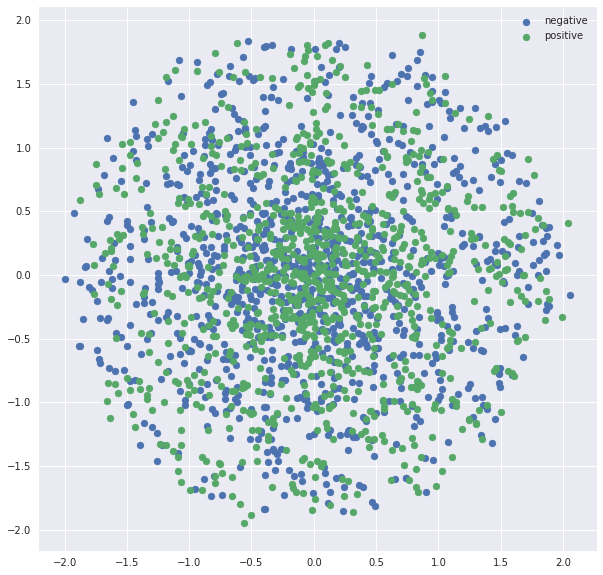

In [66]:
plt.figure(figsize=(10,10))
for no, i in enumerate(unique_ids):
    plt.scatter(doc_tsne[newsgroups_train.target==i,0],
               doc_tsne[newsgroups_train.target==i,1],
               label=newsgroups_train.target_names[no],color=colors[no])
plt.legend()
plt.show()

In [67]:
from sklearn.decomposition import *
pca = PCA(n_components=2)
svd = TruncatedSVD(n_components=2)

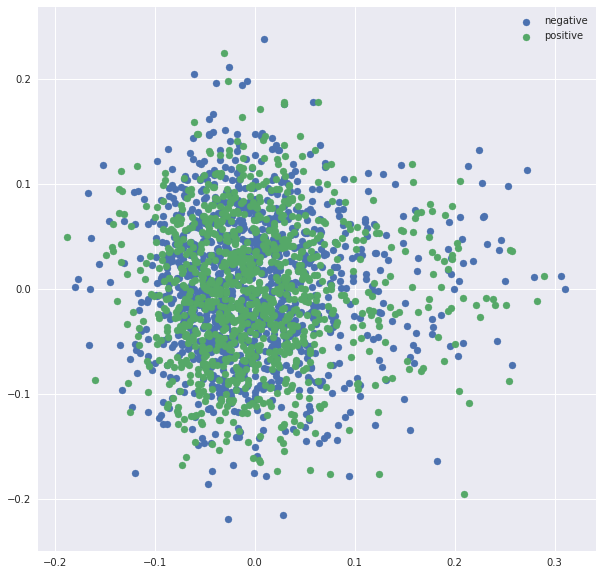

In [68]:
doc_pca = pca.fit_transform(doc_vectors)
plt.figure(figsize=(10,10))
for no, i in enumerate(unique_ids):
    plt.scatter(doc_pca[newsgroups_train.target==i,0],
               doc_pca[newsgroups_train.target==i,1],
               label=newsgroups_train.target_names[no],color=colors[no])
plt.legend()
plt.show()

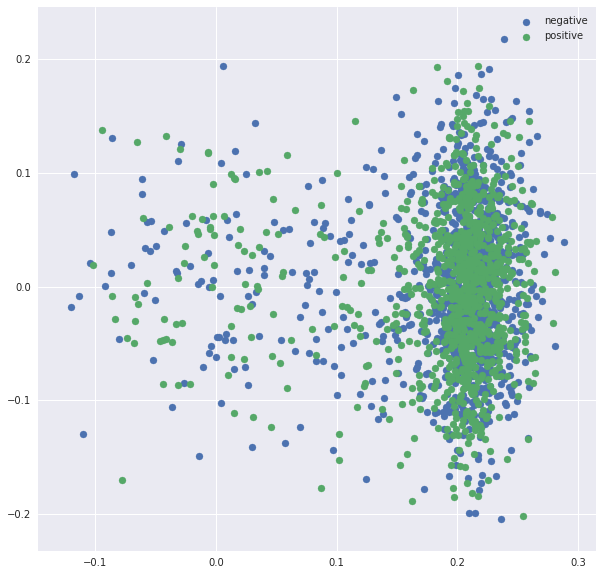

In [70]:
doc_svd = svd.fit_transform(doc_vectors)
plt.figure(figsize=(10,10))
for no, i in enumerate(unique_ids):
    plt.scatter(doc_svd[newsgroups_train.target==i,0],
               doc_svd[newsgroups_train.target==i,1],
               label=newsgroups_train.target_names[no],color=colors[no])
plt.legend()
plt.show()